In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#tf 2.1+ required for preprocessing
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.1


In [3]:
train_dataset = pd.read_csv('C:\\Users\\kpostma\\OneDrive - DOI\\NLCDShrub\\nlcd_ml\\imp2019_clg10_p19_r37\\leafon\\imp2019_clg10_p19_r37.header.data')
test_dataset = pd.read_csv('C:\\Users\\kpostma\\OneDrive - DOI\\NLCDShrub\\nlcd_ml\\imp2019_clg10_p19_r37\\leafon\\imp2019_clg10_p19_r37.header.test')
#drop x/y columns
trash_x = train_dataset.pop('x')
trash_y = train_dataset.pop('y')
trash_x = test_dataset.pop('x')
trash_y = test_dataset.pop('y')

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('dep')
test_labels = test_features.pop('dep')

#With only one dataset use the following two to split it into train and test datasets
#train_dataset = dftrain.sample(frac=0.8, random_state=0)
#test_dataset = dftrain.drop(train_dataset.index)

In [3]:
train_dataset.head()

,band01,band02,band03,band04,band05,band06,dep
0,393,775,798,2983,2645,1587,14
1,587,905,1043,1990,2122,1535,43
2,253,553,502,3240,2274,1312,0
3,250,399,276,2928,1581,659,1
4,165,385,226,3239,1537,551,0


In [4]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
band01,12905.0,416.151414,442.176148,0.0,194.0,285.0,478.0,5707.0
band02,12905.0,677.355134,517.076115,158.0,395.0,527.0,772.0,6703.0
band03,12905.0,617.596978,627.796036,37.0,234.0,414.0,776.0,7311.0
band04,12905.0,2917.205579,685.638785,96.0,2550.0,2935.0,3313.0,7914.0
band05,12905.0,1870.883688,741.460230,1.0,1365.0,1688.0,2277.0,6279.0
band06,12905.0,1017.780938,621.839518,7.0,530.0,831.0,1372.0,5363.0
dep,12905.0,19.589229,30.451874,0.0,0.0,0.0,36.0,100.0


In [5]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
band01,416.151414,442.176148
band02,677.355134,517.076115
band03,617.596978,627.796036
band04,2917.205579,685.638785
band05,1870.883688,741.460230
band06,1017.780938,621.839518
dep,19.589229,30.451874


In [6]:
test_dataset.head()

,band01,band02,band03,band04,band05,band06,dep
0,309,477,373,2687,1643,783,0
1,175,370,232,2784,1227,470,0
2,166,359,219,3168,1477,551,0
3,214,441,272,2866,1403,571,0
4,128,292,193,2357,1048,406,0


In [7]:
test_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
band01,500.0,306.596,265.816964,63.0,176.75,231.5,363.25,4196.0
band02,500.0,549.328,323.329889,268.0,375.75,445.0,640.25,4828.0
band03,500.0,459.480,418.619127,128.0,219.75,300.5,582.50,5351.0
band04,500.0,2947.700,698.009981,160.0,2614.25,2994.0,3347.75,5901.0
band05,500.0,1739.512,728.842928,53.0,1285.25,1563.5,2140.50,5039.0
band06,500.0,859.264,553.383676,35.0,495.75,651.5,1135.00,3768.0
dep,500.0,6.856,17.541570,0.0,0.00,0.0,0.00,100.0


In [8]:
test_dataset.describe().transpose()[['mean', 'std']]

,mean,std
band01,306.596,265.816964
band02,549.328,323.329889
band03,459.480,418.619127
band04,2947.700,698.009981
band05,1739.512,728.842928
band06,859.264,553.383676
dep,6.856,17.541570


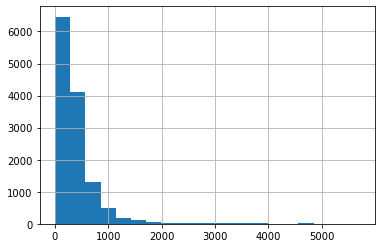

In [9]:
train_dataset.band01.hist(bins=20)
plt.show()

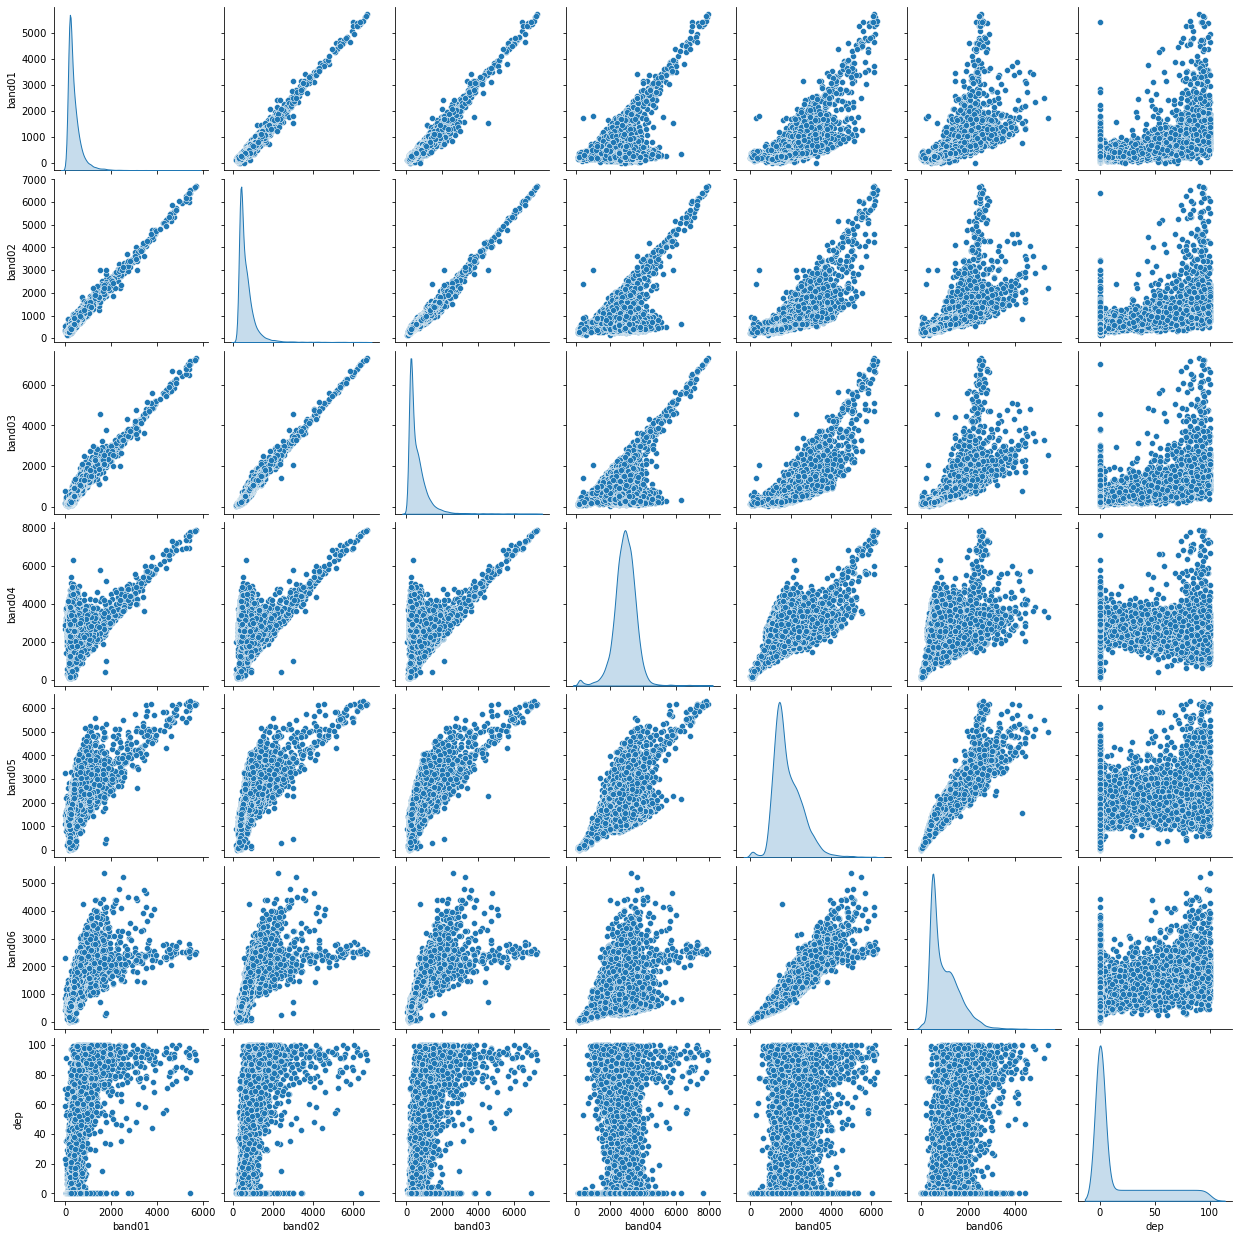

In [10]:
import seaborn as sns
sns.pairplot(train_dataset[['band01', 'band02', 'band03', 'band04', 'band05', 'band06', 'dep']], diag_kind='kde')

In [11]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[ 416.15143  677.35516  617.597   2917.2056  1870.8837  1017.78094]


In [12]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 393  775  798 2983 2645 1587]]

Normalized: [[-0.05  0.19  0.29  0.1   1.04  0.92]]


In [13]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 20])
  plt.xlabel('Epoch')
  plt.ylabel('Error [dep]')
  plt.legend()
  plt.grid(True)

In [14]:
def build_and_compile_nlcd_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      #layers.Dense(64, activation='relu'),
      #layers.Dense(32, activation='relu'),
      #layers.Dropout(0.25),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_model = build_and_compile_nlcd_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense (Dense)                (None, 128)               896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,230
Trainable params: 9,217
Non-trainable params: 13
_________________________________________________________________


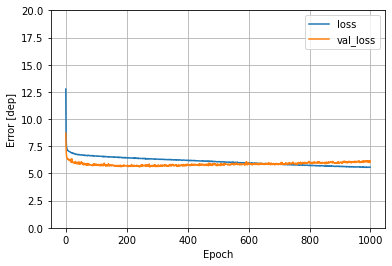

In [15]:
import time
start_time = time.perf_counter()
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)
stop_time = time.perf_counter()
total_time = stop_time - start_time
print("Total model.fit time:",total_time,"secs")
plot_loss(history)

In [16]:
test_results = {}
test_results['dnn_nlcd_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [dep]']).T

,Mean absolute error [dep]
dnn_nlcd_model,4.694033


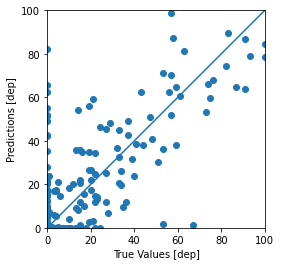

In [17]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [dep]')
plt.ylabel('Predictions [dep]')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

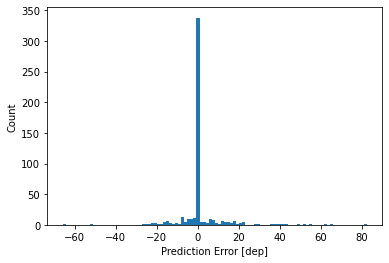

In [18]:
error = test_predictions - test_labels
plt.hist(error, bins=100)
plt.xlabel('Prediction Error [dep]')
_ = plt.ylabel('Count')

In [19]:
history.history['loss'][-5:]

[5.581325531005859,
 5.571948528289795,
 5.578222274780273,
 5.588391304016113,
 5.57822847366333]

In [20]:
dnn_model.save('nlcd.dnn_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: nlcd.dnn_model\assets


,Mean absolute error [dep]
dnn_nlcd_model,4.694033
reloaded,4.694033


In [5]:
dnn_model = tf.keras.models.load_model('nlcd.dnn_model')
#test_results = {}
test_results['reloaded'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [dep]']).T

,Mean absolute error [dep]
reloaded,4.694033


In [6]:
#GDAL Imports and Functions

from osgeo import gdal
def load_ds(filepath, readonly=True):
    """
    Load a raster dataset
    """
    if not readonly:
        return gdal.Open(filepath, gdal.GA_Update)

    return gdal.Open(filepath, gdal.GA_ReadOnly)

def create(path, rows, cols, affine, datatype, proj, bands, driver='HFA'):
    """
    Create a GeoTif and return the data set to work with.
    If the file exists at the given path, this will attempt to remove it.
    """
    ds = (gdal
          .GetDriverByName(driver)
          .Create(path, cols, rows, bands, datatype, options=['COMPRESS=YES']))

    ds.SetGeoTransform(affine)
    ds.SetProjection(proj)

    return ds

def nlcd_predict(model, data, outds):
    features = np.column_stack((data[1],data[2],data[3],data[4],data[5],data[6]))
    preds = model.predict(features).flatten()
    return(preds)

ModuleNotFoundError: No module named '_gdal'

In [3]:
input_path = "C:\\Users\\kpostma\\OneDrive - DOI\\NLCDShrub\\nlcd_ml\\p19_r37_leafon_2019.img"
out_root = "C:\\Users\\kpostma\\OneDrive - DOI\\NLCDShrub\\nlcd_ml\\"
ds = load_ds(input_path)
if not ds:
    print("Image cannot be opened:",input_path)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()

BAND_COUNT = ds.RasterCount
if BAND_COUNT <= 0:
    print("Image contains no raster bands:",input_path)

(BLK_SZ_X, BLK_SZ_Y) = ds.GetRasterBand(1).GetBlockSize()
SIZE_X = ds.RasterXSize
SIZE_Y = ds.RasterYSize
print("DS size: ("+str(SIZE_X)+","+str(SIZE_Y)+")  Block size: ("+str(BLK_SZ_X)+","+str(BLK_SZ_Y)+")")

print(ds.GetDescription())
data = {}
for idx in range(6):
    data[idx+1] = ds.GetRasterBand(idx+1).ReadAsArray()
    nodata = ds.GetRasterBand(idx+1).GetNoDataValue()
    (min,max,mean,sd) = ds.GetRasterBand(idx+1).ComputeStatistics(True)
    print("Band{}: Min={:.3f}, Max={:.3f}, Mean={:.3f}, StdDev={:.3f}, NoData={}".format(idx+1,min,max,mean,sd,nodata))

outds = create(out_root + 'nlcd_out.img', ds.RasterYSize, ds.RasterXSize, geo, gdal.GDT_Byte, proj, num_bands)

NameError: name 'load_ds' is not defined

In [38]:
#TEST ONLY
print(train_features['band01'])
data = {}
data[1] = train_features['band01']
data[2] = train_features['band02']
data[3] = train_features['band03']
data[4] = train_features['band04']
data[5] = train_features['band05']
data[6] = train_features['band06']
print(data)
outds = []
#TEST ONLY

0        393
1        587
2        253
3        250
4        165
        ... 
12900    361
12901    219
12902    379
12903    225
12904    252
Name: band01, Length: 12905, dtype: int64
{1: 0        393
1        587
2        253
3        250
4        165
        ... 
12900    361
12901    219
12902    379
12903    225
12904    252
Name: band01, Length: 12905, dtype: int64, 2: 0        775
1        905
2        553
3        399
4        385
        ... 
12900    614
12901    472
12902    623
12903    435
12904    414
Name: band02, Length: 12905, dtype: int64, 3: 0         798
1        1043
2         502
3         276
4         226
         ... 
12900     540
12901     301
12902     560
12903     308
12904     228
Name: band03, Length: 12905, dtype: int64, 4: 0        2983
1        1990
2        3240
3        2928
4        3239
         ... 
12900    3363
12901    3847
12902    3175
12903    2938
12904    3410
Name: band04, Length: 12905, dtype: int64, 5: 0        2645
1        2122
2    

In [45]:
output = nlcd_predict(dnn_model, data, outds)
print(output.shape)
print(train_labels.shape)

(12905,)
(12905,)


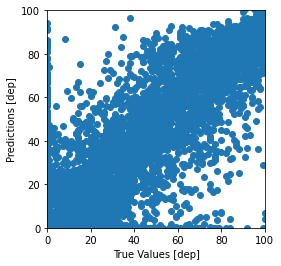

In [46]:
a = plt.axes(aspect='equal')
plt.scatter(train_labels, output)
plt.xlabel('True Values [dep]')
plt.ylabel('Predictions [dep]')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

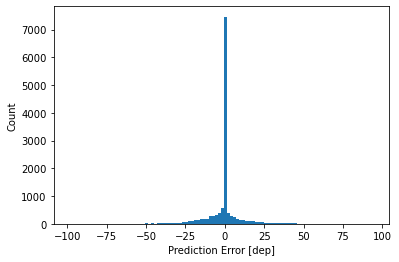

In [47]:
error = output - train_labels
plt.hist(error, bins=100)
plt.xlabel('Prediction Error [dep]')
_ = plt.ylabel('Count')